# Model 

In [84]:
import pandas as pd 
import numpy as np 
import pandas_profiling
from janitor import clean_names

In [85]:
add = pd.read_csv('raw_data/shs_aggregate_responses.csv').clean_names()
add.shape

(58530, 13)

In [86]:
add.isna().sum()
add.dropna().shape
add.columns

Index(['year', 'community_belonging', 'neighbourhood_rating',
       'distance_to_nearest_green_space',
       'satisfaction_with_nearest_green_space', 'age', 'gender',
       'economic_status', 'household_size', 'highest_education_level',
       'nearest_green_space_use', 'volunteering_last_twelve_months',
       'n_persons'],
      dtype='object')

In [87]:
#pandas_profiling.ProfileReport(add)

### Tidying 

In [88]:
# this dataset has a lot more information that I didn't have with the other data set 
# I want to keep them similar but I also don't want to get ride of all the extra ones 
# I will drop the ones that are far too different to my original data(eg. volunteering last 12 months)
# what is n_persons? 

In [89]:
add.drop(['year', 'volunteering_last_twelve_months', 'n_persons','highest_education_level'], axis = 1, inplace = True)
add.dropna(inplace = True)
add.isna().sum()

community_belonging                      0
neighbourhood_rating                     0
distance_to_nearest_green_space          0
satisfaction_with_nearest_green_space    0
age                                      0
gender                                   0
economic_status                          0
household_size                           0
nearest_green_space_use                  0
dtype: int64

In [90]:
add = add[add.distance_to_nearest_green_space != "Don't know"].copy()

In [91]:
(add['distance_to_nearest_green_space'].replace({'A 5 minute walk or less': 1,
                                         'More than a 30 minute walk away': 0,
                                         'Within a 21-30 minute walk': 0,
                                         'Within a 6-10 minute walk':1,
                                         'Within an 11-20 minute walk': 0}, inplace = True)
)

In [92]:
add_d = pd.get_dummies(add, drop_first = True)

add_d.head()

,distance_to_nearest_green_space,household_size,community_belonging_Fairly strongly,community_belonging_Not at all strongly,community_belonging_Not very strongly,community_belonging_Very strongly,neighbourhood_rating_Fairly poor,neighbourhood_rating_No opinion,neighbourhood_rating_Very good,neighbourhood_rating_Very poor,...,economic_status_Retired,economic_status_Self Employed,economic_status_Training,nearest_green_space_use_Every day,nearest_green_space_use_Less often,nearest_green_space_use_Not at all,nearest_green_space_use_Once a month,nearest_green_space_use_Once a week,nearest_green_space_use_Several times a month,nearest_green_space_use_Several times a week
6778,1,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
6779,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
6780,1,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
6781,1,3,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
6782,1,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [93]:
predictors = add_d.drop(columns = "distance_to_nearest_green_space")
response = add_d["distance_to_nearest_green_space"]

In [94]:
from sklearn.model_selection import train_test_split
pred_train,pred_test, resp_train, resp_test = (
    train_test_split(
        predictors, 
        response, 
        test_size = 0.1, 
        random_state = 7
    )
)

In [95]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators = 100)

model.fit(pred_train, resp_train)

RandomForestClassifier()

In [96]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(
    model, pred_train, resp_train, scoring='accuracy', cv=10
)
np.mean(scores)

0.8390400770986248

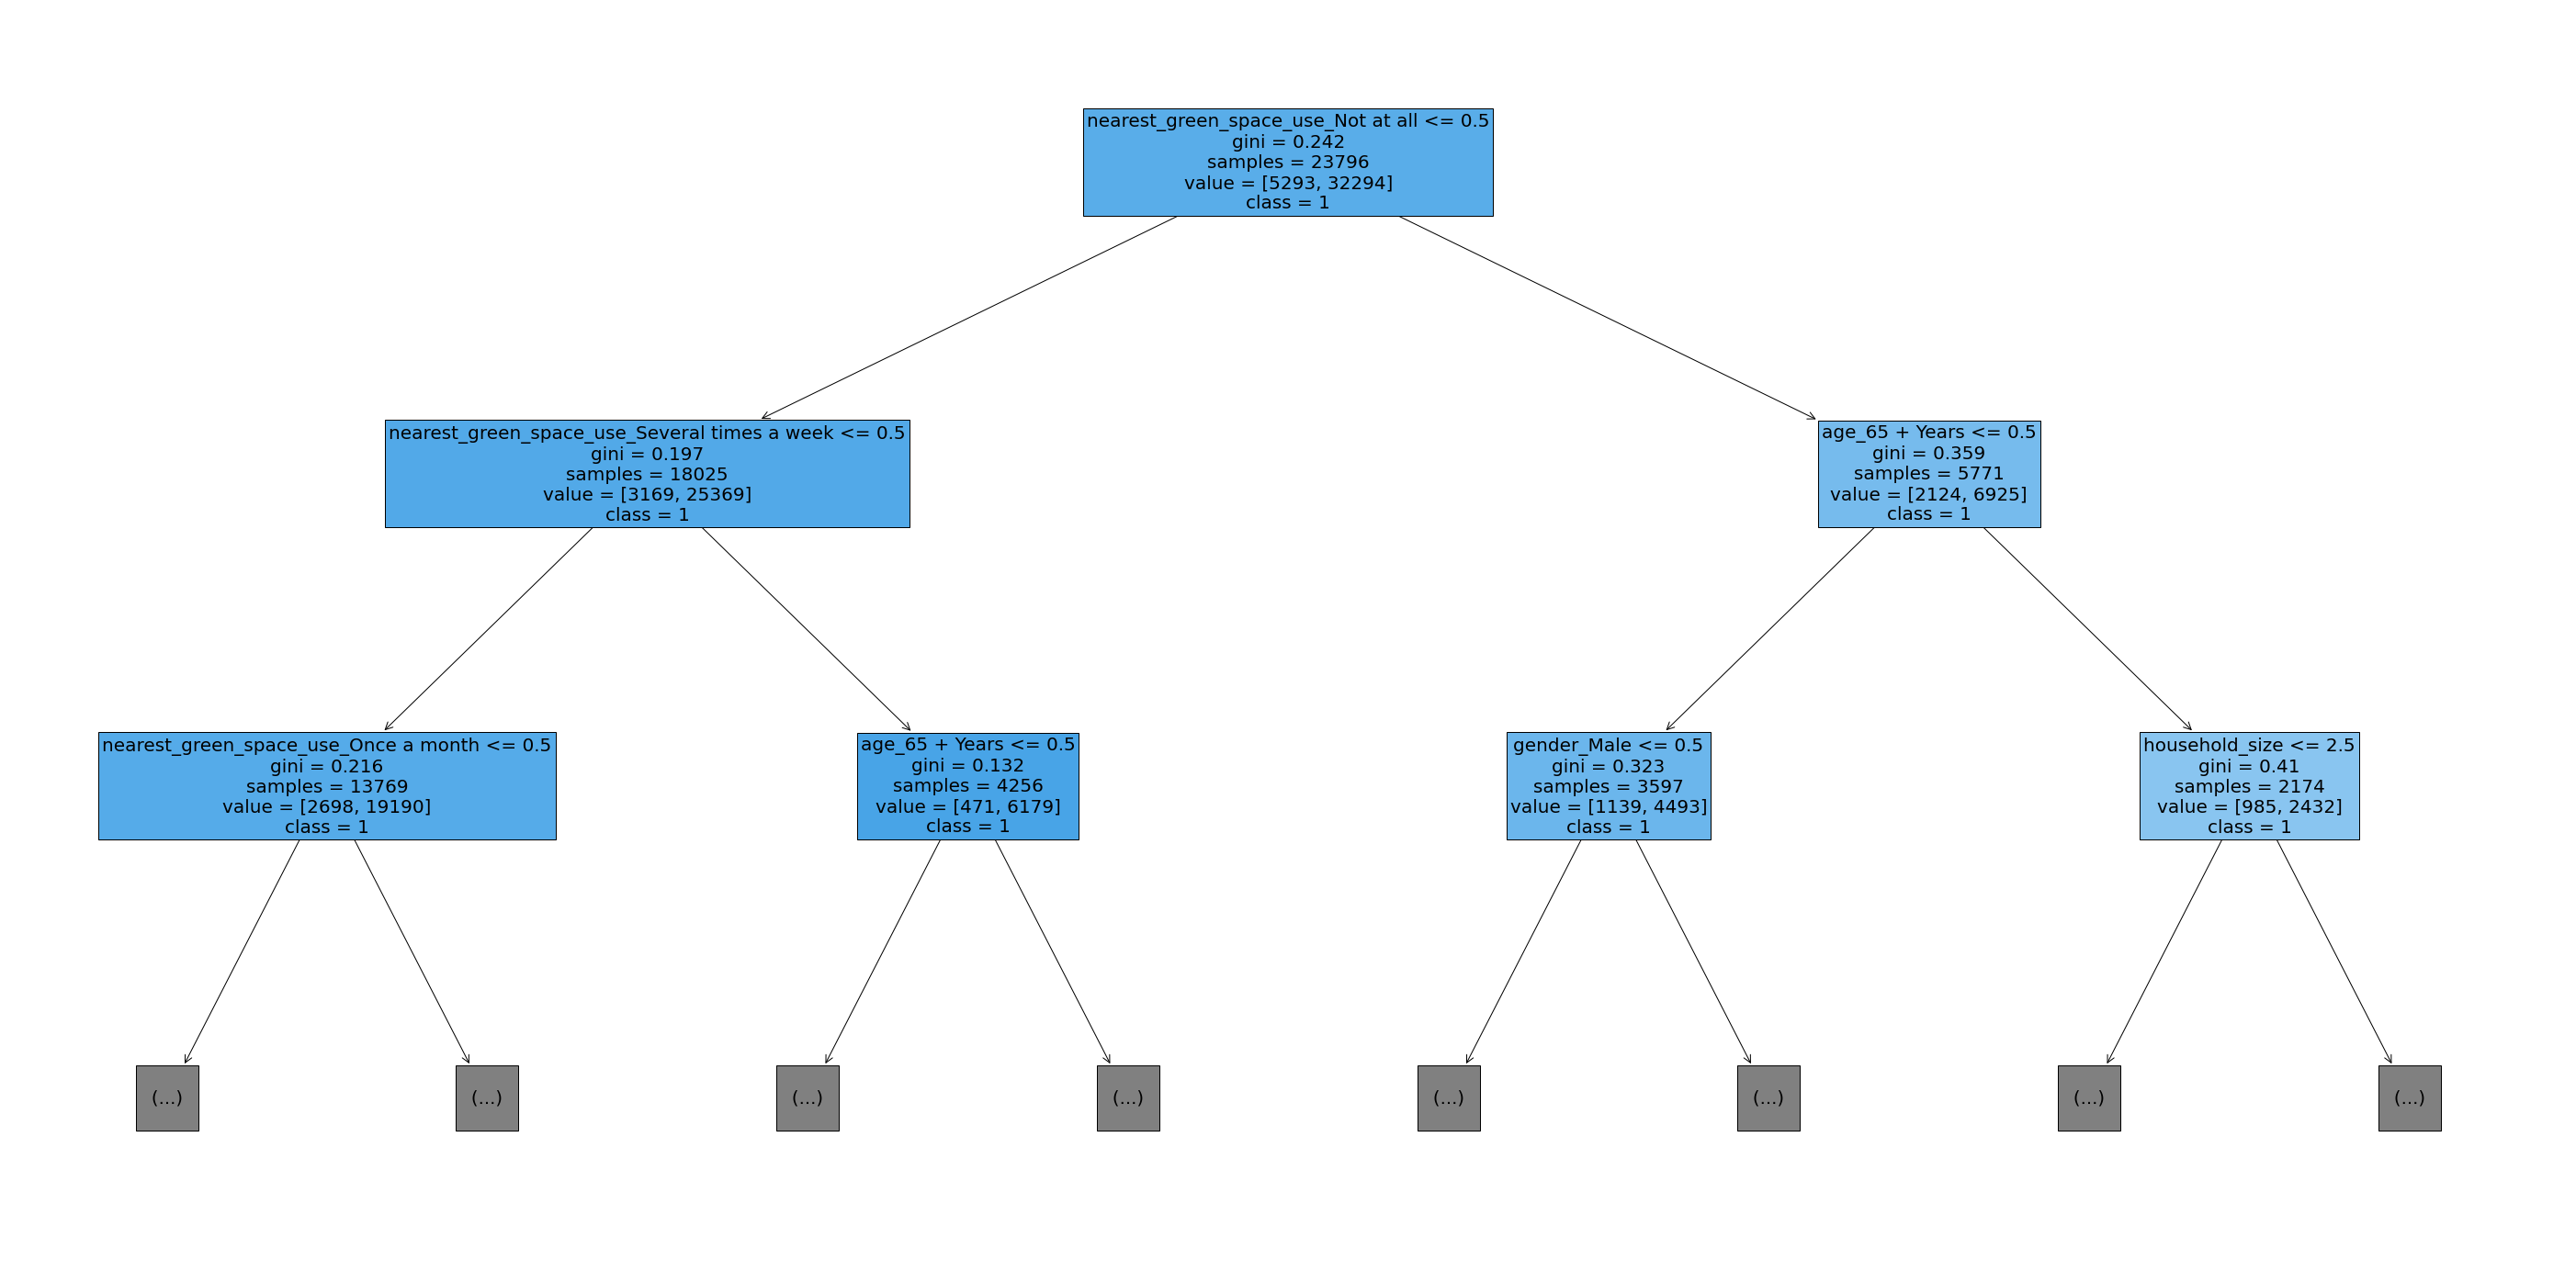

In [97]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree


pred_names = list(pred_test)
resp_names = ['0', '1']


fig = plt.figure(figsize=(50, 25))


plot_tree(model.estimators_[0], 
          max_depth = 2, 
          feature_names = pred_names,
          class_names = resp_names, 
          filled=True,
          fontsize=20
         )

plt.savefig('clean_data/tree.png')

In [98]:
importances = list(model.feature_importances_)

feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(pred_names, importances)]

feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

[print('Variable: {:40} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: household_size                           Importance: 0.23
Variable: neighbourhood_rating_Very good           Importance: 0.07
Variable: gender_Male                              Importance: 0.07
Variable: age_35 - 64 Years                        Importance: 0.05
Variable: economic_status_Other                    Importance: 0.04
Variable: community_belonging_Fairly strongly      Importance: 0.03
Variable: community_belonging_Not very strongly    Importance: 0.03
Variable: community_belonging_Very strongly        Importance: 0.03
Variable: neighbourhood_rating_Fairly poor         Importance: 0.03
Variable: satisfaction_with_nearest_green_space_Fairly satisfied Importance: 0.03
Variable: satisfaction_with_nearest_green_space_Neither satisfied nor dissatisfied Importance: 0.03
Variable: satisfaction_with_nearest_green_space_No opinion Importance: 0.03
Variable: satisfaction_with_nearest_green_space_Very satisfied Importance: 0.03
Variable: economic_status_Part Time Employment    

In [99]:
### ummmm not very good 

# model 2 tree

In [100]:
add.columns

Index(['community_belonging', 'neighbourhood_rating',
       'distance_to_nearest_green_space',
       'satisfaction_with_nearest_green_space', 'age', 'gender',
       'economic_status', 'household_size', 'nearest_green_space_use'],
      dtype='object')

In [101]:
add.neighbourhood_rating.unique()

array(['Fairly good', 'No opinion', 'Very good', 'Very poor',
       'Fairly poor'], dtype=object)

In [102]:
(add['neighbourhood_rating'].replace({'Fairly good': 4,
                                         'Very good': 5,
                                         'Very poor': 1,
                                         'No opinion':3,
                                         'Fairly poor': 2}, inplace = True)
)

In [103]:
add.community_belonging.unique()

array(["Don't know", 'Fairly strongly', 'Not at all strongly',
       'Not very strongly', 'Very strongly'], dtype=object)

In [104]:
(add['community_belonging'].replace({'Fairly strongly': 4,
                                         'Very strongly': 5,
                                         'Not at all strongly': 1,
                                         "Don't know":3,
                                         'Not very strongly': 2}, inplace = True)
)

In [105]:
add.economic_status.unique()

array(['Full Time Employment', 'Training', 'Part Time Employment',
       'Other', 'Retired', 'Self Employed'], dtype=object)

In [106]:
(add['economic_status'].replace({'Full Time Employment': 1,
                                         'Training': 0,
                                         'Part Time Employment': 1,
                                         'Other':0,
                                         'Retired':0,
                                         'Self Employed': 1}, inplace = True)
)
#recoded as Salaried or not 

In [107]:
add.satisfaction_with_nearest_green_space.unique()

array(['Fairly dissatisfied', 'Fairly satisfied',
       'Neither satisfied nor dissatisfied', 'No opinion',
       'Very satisfied', 'Very dissatisfied'], dtype=object)

In [108]:
(add['satisfaction_with_nearest_green_space'].replace({'Fairly dissatisfied': 2,
                                         'Fairly satisfied': 5,
                                         'Neither satisfied nor dissatisfied': 4,
                                         'No opinion':3,
                                         'Very satisfied':6,
                                         'Very dissatisfied': 1}, inplace = True)
)

In [26]:
add.nearest_green_space_use.unique()

array(['Several times a month', 'Once a week', 'Once a month',
       'Several times a week', 'Every day', 'Not at all', 'Less often',
       "Don't know"], dtype=object)

In [109]:
(add['nearest_green_space_use'].replace({'Several times a month': 4,
                                         'Once a week': 5,
                                         'Once a month': 2,
                                         'Several times a week':6,
                                         'Every day':7,
                                         'Not at all': 1,
                                        'Less often':3 ,
                                        "Don't know":0}, inplace = True)
)

In [110]:
add_2 = pd.get_dummies(add, drop_first = True)

add_2.head()
#add_2.to_csv('clean_data/add_green.csv',index=False) 

,community_belonging,neighbourhood_rating,distance_to_nearest_green_space,satisfaction_with_nearest_green_space,economic_status,household_size,nearest_green_space_use,age_35 - 64 Years,age_65 + Years,gender_Male
6778,3,4,1,2,1,3,4,0,0,1
6779,3,4,1,5,1,1,5,0,0,0
6780,3,4,1,5,1,2,5,0,0,0
6781,3,4,1,5,0,3,2,0,0,0
6782,3,4,1,5,1,3,5,0,0,1


In [111]:
predictors = add_2.drop(columns = "distance_to_nearest_green_space")
response = add_2["distance_to_nearest_green_space"]

In [112]:
from sklearn.model_selection import train_test_split
pred_train,pred_test, resp_train, resp_test = (
    train_test_split(
        predictors, 
        response, 
        test_size = 0.1, 
        random_state = 7
    )
)

In [113]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators = 100)

model.fit(pred_train, resp_train)

RandomForestClassifier()

In [32]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(
    model, pred_train, resp_train, scoring='accuracy', cv=10
)
np.mean(scores)

0.8439621367826671

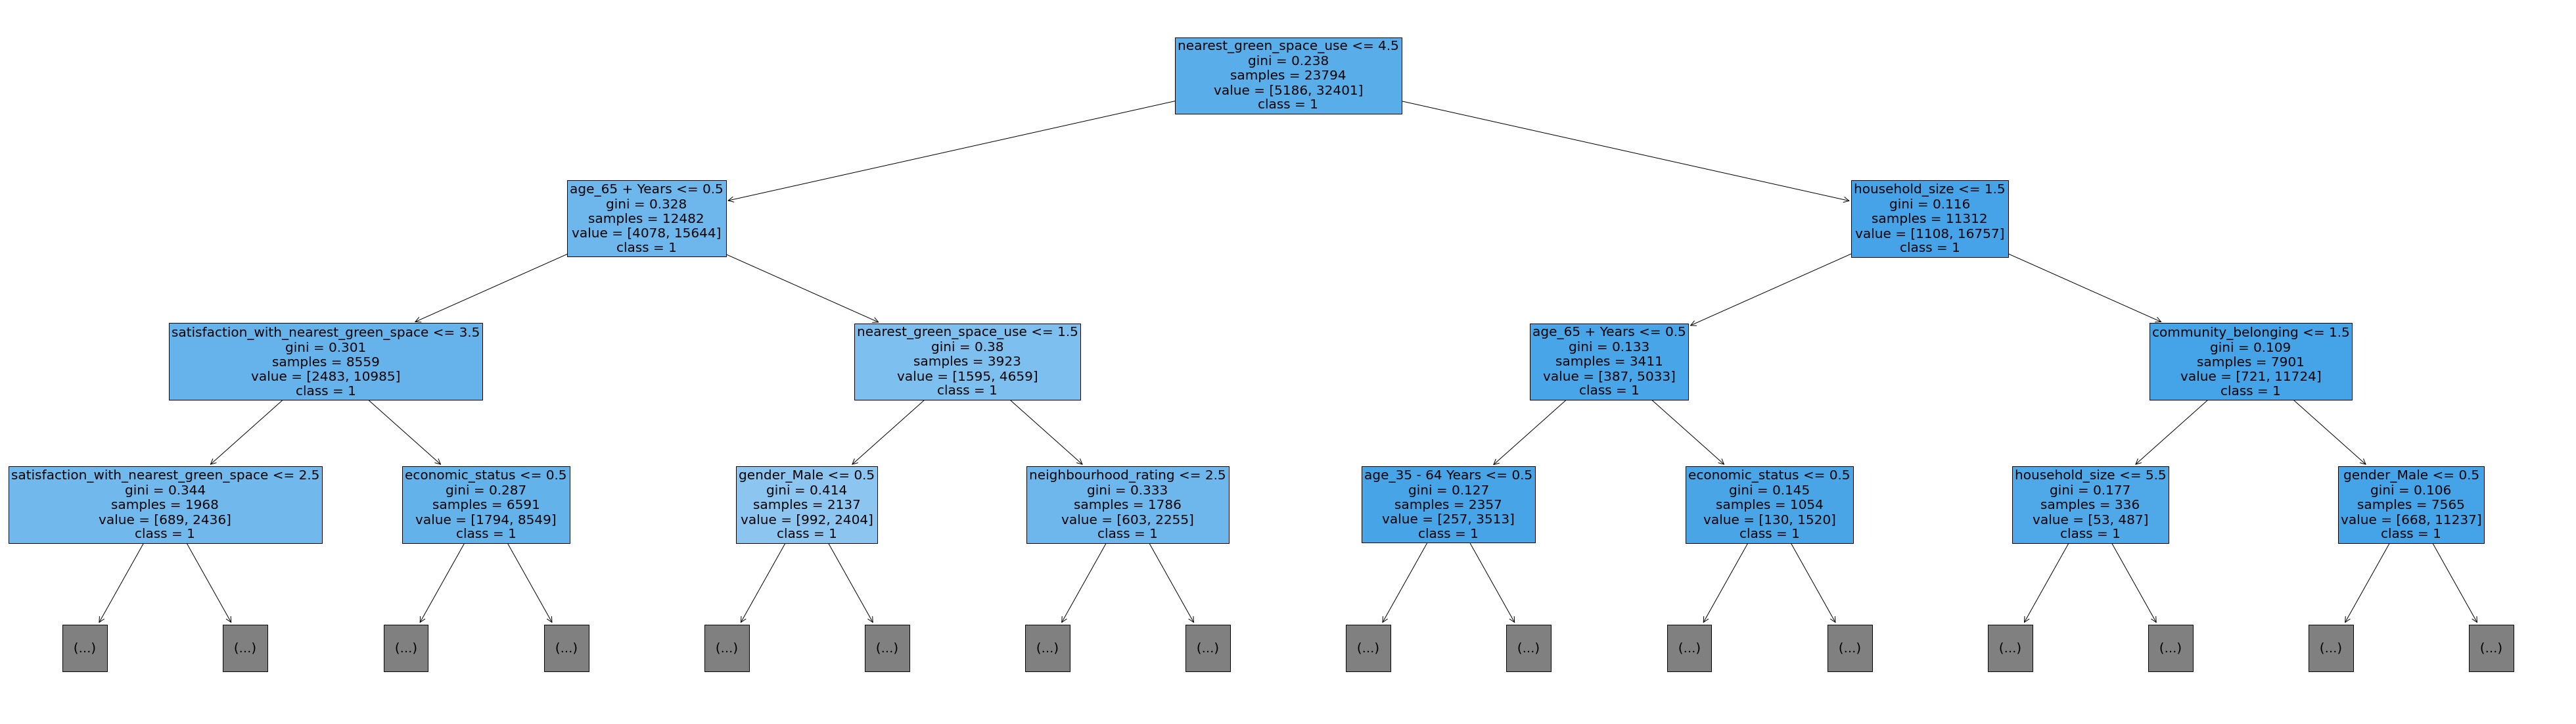

In [116]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree


pred_names = list(pred_test)
resp_names = ['0', '1']


fig = plt.figure(figsize=(70, 20))


plot_tree(model.estimators_[0], 
          max_depth = 3, 
          feature_names = pred_names,
          class_names = resp_names, 
          filled=True,
          fontsize=20
         )

plt.savefig('clean_data/tree_2.png')

In [115]:
feature_names=predictors.columns
feature_importance = pd.DataFrame(model.feature_importances_,  index = feature_names).sort_values(0).round(3)
feature_importance

,0
age_65 + Years,0.020
economic_status,0.034
age_35 - 64 Years,0.046
gender_Male,0.055
neighbourhood_rating,0.127
satisfaction_with_nearest_green_space,0.146
community_belonging,0.154
household_size,0.179
nearest_green_space_use,0.239


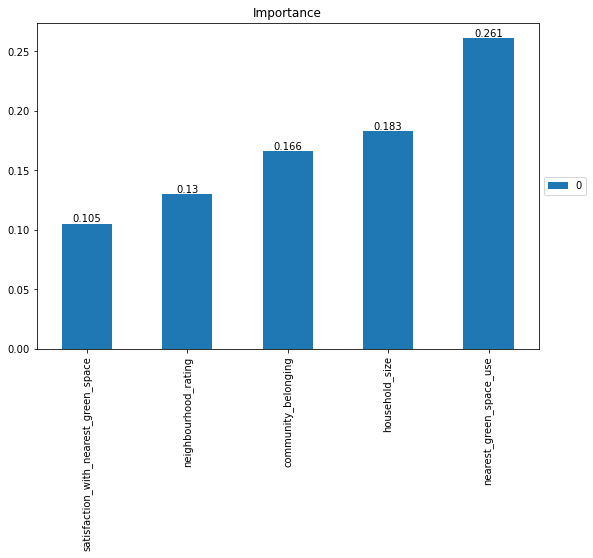

In [58]:
ax = feature_importance.tail(5).plot(
    kind = 'bar',
    stacked = True,
    title = 'Importance',
    mark_right = True,
    figsize = (9,6))
for container in ax.containers:
    ax.bar_label(container,label_type='edge')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

<AxesSubplot:>

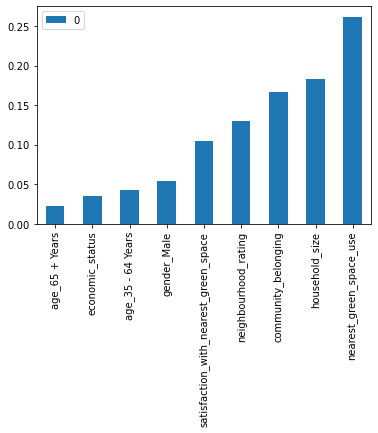

In [42]:
feature_importance.plot(kind = 'bar')

In [57]:
importances = list(model.feature_importances_)

feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(pred_names, importances)]

feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

[print('Variable: {:10} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: nearest_green_space_use Importance: 0.26
Variable: household_size Importance: 0.18
Variable: community_belonging Importance: 0.17
Variable: neighbourhood_rating Importance: 0.13
Variable: satisfaction_with_nearest_green_space Importance: 0.11
Variable: gender_Male Importance: 0.05
Variable: age_35 - 64 Years Importance: 0.04
Variable: economic_status Importance: 0.03
Variable: age_65 + Years Importance: 0.02


[None, None, None, None, None, None, None, None, None]

# Is there any way to predict which households would have higher ratings?

In [66]:
add = pd.read_csv('raw_data/shs_aggregate_responses.csv').clean_names()

In [67]:
add.drop(['year', 'volunteering_last_twelve_months', 'n_persons'], axis = 1, inplace = True)
add.dropna(inplace = True)
add.isna().sum()

community_belonging                      0
neighbourhood_rating                     0
distance_to_nearest_green_space          0
satisfaction_with_nearest_green_space    0
age                                      0
gender                                   0
economic_status                          0
household_size                           0
highest_education_level                  0
nearest_green_space_use                  0
dtype: int64

In [56]:
add.highest_education_level.unique()

array(['Standard grade or equiv (SVQ level 1 or 2).',
       'Degree, Professional qualification (Above SVQ Level 4)',
       'HNC/HND or equivalent (SVQ Level 4)',
       'Higher, A level or equivalent (SVQ Level 3)',
       'Other qualification'], dtype=object)

In [68]:
(add['highest_education_level'].replace({'Standard grade or equiv (SVQ level 1 or 2).': 1,
                                         'Degree, Professional qualification (Above SVQ Level 4)': 4,
                                         'HNC/HND or equivalent (SVQ Level 4)': 3,
                                         'Higher, A level or equivalent (SVQ Level 3)':2,
                                         'Other qualification':0}, inplace = True)
)

In [62]:
add.distance_to_nearest_green_space.unique()

array(['A 5 minute walk or less', 'More than a 30 minute walk away',
       'Within a 6-10 minute walk', 'Within an 11-20 minute walk',
       'Within a 21-30 minute walk'], dtype=object)

In [69]:
(add['distance_to_nearest_green_space'].replace({'A 5 minute walk or less': 5,
                                         'More than a 30 minute walk away': 1,
                                         'Within a 6-10 minute walk': 4,
                                         'Within an 11-20 minute walk':3,
                                          'Within a 21-30 minute walk':2}, inplace = True)
)

In [64]:
(add['neighbourhood_rating'].replace({'Fairly good': 4,
                                        'Very good': 5,
                                        'Very poor': 1,
                                       'No opinion':3,
                                       'Fairly poor': 2}, inplace = True)
)

In [70]:
(add['neighbourhood_rating'].replace({'Fairly good': 1,
                                       'Very good': 1,
                                       'Very poor': 0,
                                       'No opinion':0,
                                        'Fairly poor': 0}, inplace = True)
)

In [71]:
(add['community_belonging'].replace({'Fairly strongly': 4,
                                         'Very strongly': 5,
                                         'Not at all strongly': 1,
                                         "Don't know":3,
                                         'Not very strongly': 2}, inplace = True)
)

In [72]:
(add['economic_status'].replace({'Full Time Employment': 1,
                                         'Training': 0,
                                         'Part Time Employment': 1,
                                         'Other':0,
                                         'Retired':0,
                                         'Self Employed': 1}, inplace = True)
)

In [73]:
(add['satisfaction_with_nearest_green_space'].replace({'Fairly dissatisfied': 5,
                                         'Fairly satisfied': 4,
                                         'Neither satisfied nor dissatisfied': 3,
                                         'No opinion':3,
                                         'Very satisfied':5,
                                         'Very dissatisfied': 1}, inplace = True)
)

In [74]:
(add['nearest_green_space_use'].replace({'Several times a month': 4,
                                         'Once a week': 5,
                                         'Once a month': 2,
                                         'Several times a week':6,
                                         'Every day':7,
                                         'Not at all': 1,
                                        'Less often':3 ,
                                        "Don't know":0}, inplace = True)
)

In [75]:
add_3 = pd.get_dummies(add, drop_first = True)

add_3.head()
#add_3.to_csv('clean_data/add_neighbourhood_c.csv',index=False) 

,community_belonging,neighbourhood_rating,distance_to_nearest_green_space,satisfaction_with_nearest_green_space,economic_status,household_size,highest_education_level,nearest_green_space_use,age_35 - 64 Years,age_65 + Years,gender_Male
6778,3,1,5,5,1,3,1,4,0,0,1
6779,3,1,5,4,1,1,4,5,0,0,0
6780,3,1,5,4,1,2,3,5,0,0,0
6781,3,1,5,4,0,3,3,2,0,0,0
6782,3,1,5,4,1,3,1,5,0,0,1


In [76]:
predictors = add_3.drop(columns = "neighbourhood_rating")
response = add_3["neighbourhood_rating"]

In [77]:
from sklearn.model_selection import train_test_split
pred_train,pred_test, resp_train, resp_test = (
    train_test_split(
        predictors, 
        response, 
        test_size = 0.1, 
        random_state = 7
    )
)

In [78]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators = 100)

model.fit(pred_train, resp_train)

RandomForestClassifier()

In [79]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(
    model, pred_train, resp_train, scoring='accuracy', cv=10
)
np.mean(scores)

0.9351130036030135

[Text(0.5, 0.9, 'nearest_green_space_use <= 1.5\ngini = 0.102\nsamples = 19346\nvalue = [1650, 28880]\nclass = 1'),
 Text(0.25, 0.7, 'satisfaction_with_nearest_green_space <= 2.0\ngini = 0.153\nsamples = 4160\nvalue = [545, 5997]\nclass = 1'),
 Text(0.125, 0.5, 'highest_education_level <= 1.5\ngini = 0.374\nsamples = 236\nvalue = [93, 280]\nclass = 1'),
 Text(0.0625, 0.3, 'distance_to_nearest_green_space <= 2.5\ngini = 0.418\nsamples = 112\nvalue = [53, 125]\nclass = 1'),
 Text(0.03125, 0.1, '\n  (...)  \n'),
 Text(0.09375, 0.1, '\n  (...)  \n'),
 Text(0.1875, 0.3, 'economic_status <= 0.5\ngini = 0.326\nsamples = 124\nvalue = [40, 155]\nclass = 1'),
 Text(0.15625, 0.1, '\n  (...)  \n'),
 Text(0.21875, 0.1, '\n  (...)  \n'),
 Text(0.375, 0.5, 'community_belonging <= 1.5\ngini = 0.136\nsamples = 3924\nvalue = [452, 5717]\nclass = 1'),
 Text(0.3125, 0.3, 'age_35 - 64 Years <= 0.5\ngini = 0.452\nsamples = 339\nvalue = [188, 357]\nclass = 1'),
 Text(0.28125, 0.1, '\n  (...)  \n'),
 Text(0.3

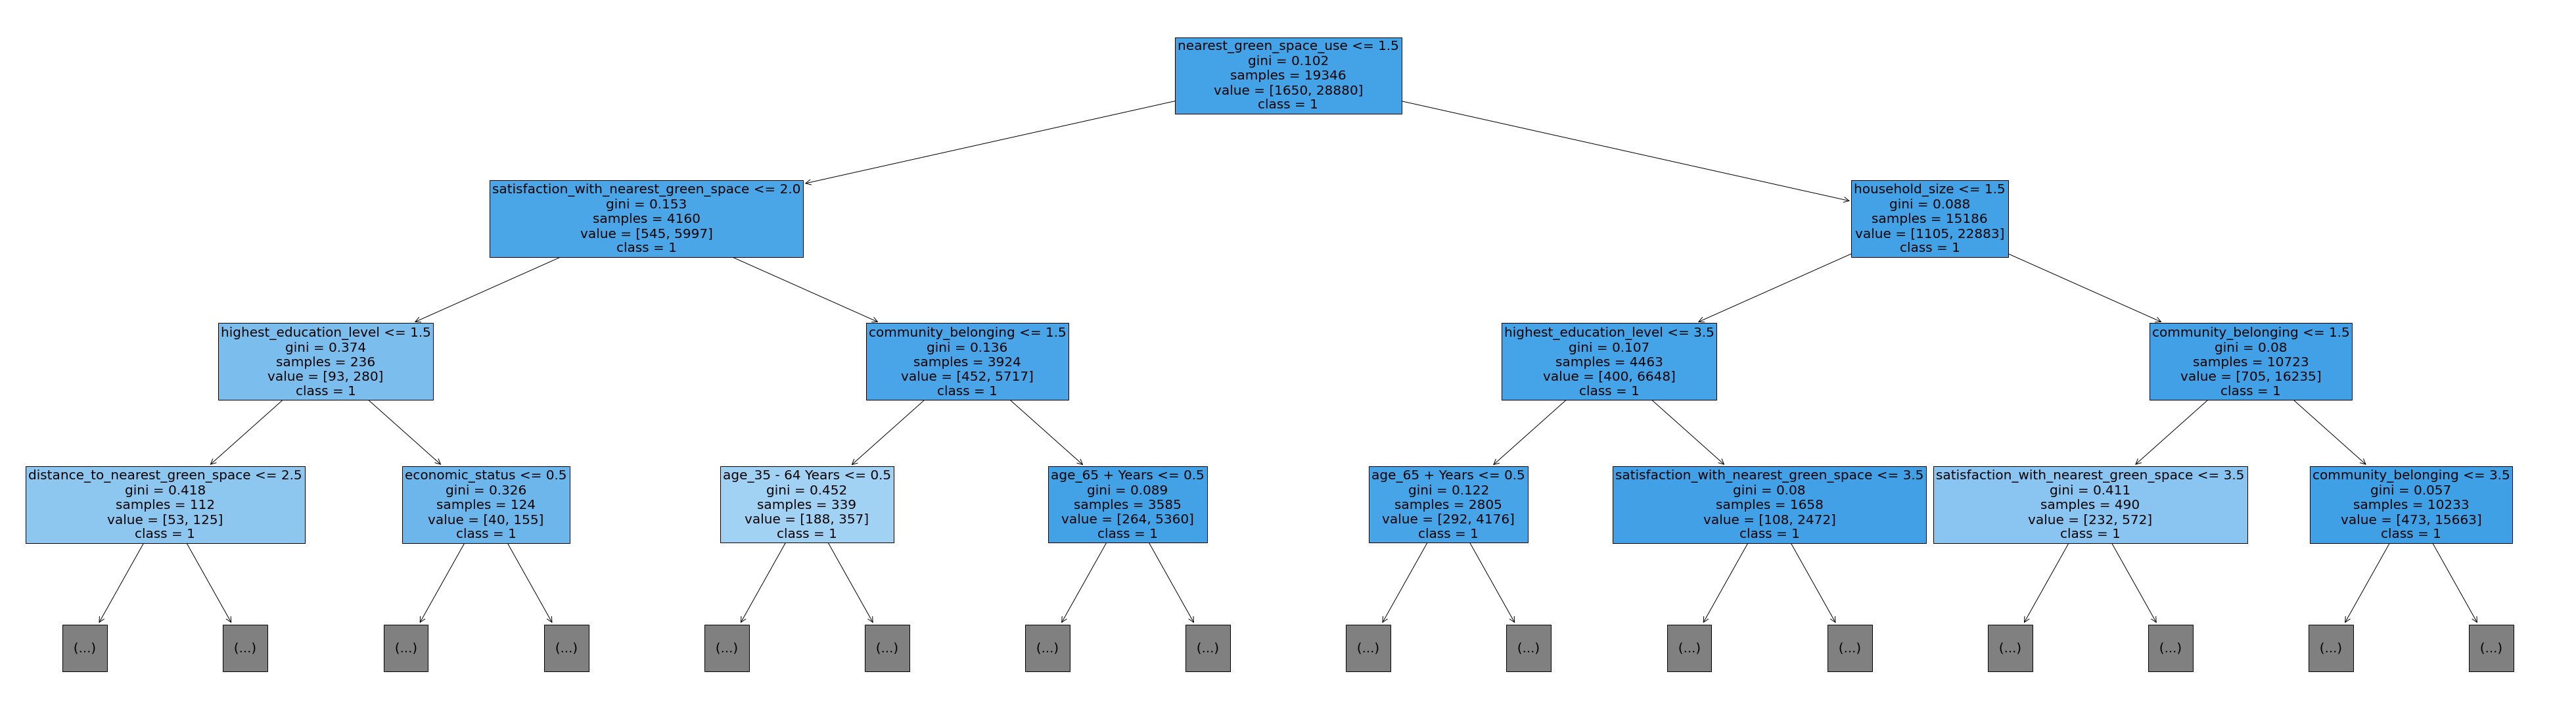

In [80]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree


pred_names = list(pred_test)
resp_names = ['0','1']


fig = plt.figure(figsize=(70, 20))


plot_tree(model.estimators_[0], 
          max_depth = 3, 
          feature_names = pred_names,
          class_names = resp_names, 
          filled=True,
          fontsize=20
         )

#plt.savefig('clean_data/tree_comm_10.png')

In [82]:
feature_names=predictors.columns
feature_importance = pd.DataFrame(model.feature_importances_,  index = feature_names).sort_values(0).round(3)
feature_importance

,0
age_65 + Years,0.015
age_35 - 64 Years,0.046
economic_status,0.047
gender_Male,0.060
satisfaction_with_nearest_green_space,0.088
highest_education_level,0.112
distance_to_nearest_green_space,0.115
household_size,0.153
community_belonging,0.175
nearest_green_space_use,0.190


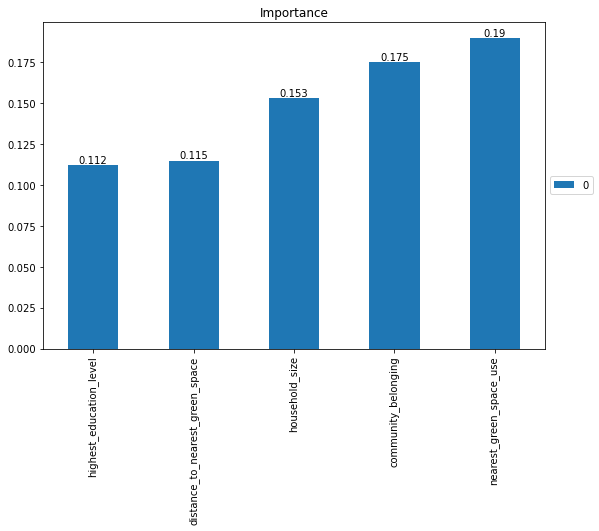

In [83]:
ax = feature_importance.tail(5).plot(
    kind = 'bar',
    stacked = True,
    title = 'Importance',
    mark_right = True,
    figsize = (9,6))
for container in ax.containers:
    ax.bar_label(container,label_type='edge')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [81]:
importances = list(model.feature_importances_)

feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(pred_names, importances)]

feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

[print('Variable: {:10} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: nearest_green_space_use Importance: 0.19
Variable: community_belonging Importance: 0.18
Variable: household_size Importance: 0.15
Variable: distance_to_nearest_green_space Importance: 0.12
Variable: highest_education_level Importance: 0.11
Variable: satisfaction_with_nearest_green_space Importance: 0.09
Variable: gender_Male Importance: 0.06
Variable: economic_status Importance: 0.05
Variable: age_35 - 64 Years Importance: 0.05
Variable: age_65 + Years Importance: 0.01


[None, None, None, None, None, None, None, None, None, None]